In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader,TensorDataset
from gensim.models import Word2Vec

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class GRUVAE(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, latent_dim, style_dim, content_dim, vocab_size, sos_token, num_layers):
        super(GRUVAE, self).__init__()

        self.embedding_dim = embedding_matrix.shape[1]
        self.sos_token = sos_token

        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze = True)
        self.layer_norm = nn.LayerNorm(self.embedding_dim)
        self.encoder = nn.LSTM(self.embedding_dim, hidden_dim, num_layers, batch_first=True) # (N,B,H) N batches, B sequence length, H input dim
        self.encoder_content = nn.GRU(self.embedding_dim, hidden_dim, num_layers, batch_first=True)
        self.fcmu_s = nn.Linear(hidden_dim, style_dim)
        self.fcvar_s = nn.Linear(hidden_dim, style_dim)
        self.fcmu_c = nn.Linear(hidden_dim, content_dim)
        self.fcvar_c = nn.Linear(hidden_dim, content_dim)

        self.fc_s = nn.Linear(hidden_dim, style_dim)
        self.fc_c = nn.Linear(hidden_dim, content_dim)
        self.fclatent = nn.Linear(hidden_dim, latent_dim)

        self.fc = nn.Linear(latent_dim, hidden_dim)
        self.decoder = nn.GRU(self.embedding_dim, hidden_dim, num_layers,batch_first=True)
        self.fc_out = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        embedded_input = self.embedding(x)
        #out = self.layer_norm(embedded_input)
        _, (hn, cn) = self.encoder(embedded_input)
        
        mu_s = self.fcmu_s(hn)
        logvar_s = self.fcvar_s(hn)
        mu_c = self.fcmu_c(hn)
        logvar_c = self.fcvar_c(hn)

        style = self.reparametrization(mu_s, logvar_s)
        content = self.reparametrization(mu_c, logvar_c)
        z = torch.cat((style,content), dim = 2)
        z = self.fc(z)

        sos_token = self.sos_token.repeat(x.size(0),1)
        sos_token = self.embedding(sos_token)
        decoder_input = torch.cat((sos_token, embedded_input), dim = 1)
        decoder_input = decoder_input[:,:-1,:]

        '''output = []
        for t in range(decoder_input.shape[1]):
            outputs, _ = self.decoder(decoder_input[:,t,:].unsqueeze(1), z)
            output.append(outputs)'''
        
        reconstructed_sequence = []
        for t in range(x.shape[1]):
            outputs, _ = self.decoder(decoder_input[:,:t+1,:], z)
            #outputs = self.fc_out(outputs)
            #output.append(outputs)
            #decoder_input = self.embedding(torch.argmax(outputs, dim = -1))
            #next_token = self.embedding(torch.multinomial(F.softmax(outputs[:,-1,:].mean(dim=0), dim = -1), 1)) # PROVA A USARE MULTINOMIAL NELL'INFERENCE STEP
            #next_token = self.embedding(torch.argmax(F.softmax(outputs[:,-1,:], dim = -1), dim=-1))
            #reconstructed_sequence = torch.cat((sos_token, next_token.unsqueeze(1)), dim=1)
            reconstructed_sequence.append(outputs[:,-1,:].unsqueeze(1))

        reconstructed_sequence = torch.cat(reconstructed_sequence, dim=1)
        reconstructed_sequence = self.fc_out(reconstructed_sequence)

        return reconstructed_sequence, style, content, mu_s, logvar_s, mu_c, logvar_c


    def reparametrization(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return mu + eps*std
    
    def reconstruction(self, x):
        embedded_input = self.embedding(x)
        #out = self.layer_norm(embedded_input)
        _, (hn, cn) = self.encoder(embedded_input)
        
        mu_s = self.fcmu_s(hn)
        logvar_s = self.fcvar_s(hn)
        mu_c = self.fcmu_c(hn)
        logvar_c = self.fcvar_c(hn)

        style = self.reparametrization(mu_s, logvar_s)
        content = self.reparametrization(mu_c, logvar_c)
        z = torch.cat((style,content), dim = 2)
        z = self.fc(z)

        sos_token = self.sos_token.repeat(x.size(0),1)
        sos_token = self.embedding(sos_token)
        decoder_input = sos_token

        output = sos_token
        for _ in range(x.shape[1]):
            outputs, _ = self.decoder(output, z)
            outputs = self.fc_out(outputs)
            #decoder_input = self.embedding(torch.argmax(outputs, dim = -1))
            #next_token = self.embedding(torch.multinomial(F.softmax(outputs[:,-1,:].mean(dim=0), dim = -1), 1)) # PROVA A USARE MULTINOMIAL NELL'INFERENCE STEP
            next_token = torch.argmax(F.softmax(outputs[:,-1,:], dim = -1), dim=-1)
            next_token = self.embedding(next_token)
            output = torch.cat((output, next_token.unsqueeze(1)), dim=1)
        
        return outputs
    
    def TST(self, x, new_style):
        embedded_input = self.embedding(x)
        #out = self.layer_norm(embedded_input)
        _, (hn, cn) = self.encoder(embedded_input)

        mu_c = self.fcmu_c(hn)
        log_var_c = self.fcvar_c(hn)

        content = self.reparametrization(mu_c,log_var_c)

        z = torch.cat((new_style,content), dim = 2)
        z = self.fc(z)

        sos_token = self.sos_token.repeat(x.size(0),1)
        sos_token = self.embedding(sos_token)
        decoder_input = sos_token

        output = sos_token
        for _ in range(x.shape[1]):
            outputs, _ = self.decoder(output, z)
            outputs = self.fc_out(outputs)
            #decoder_input = self.embedding(torch.argmax(outputs, dim = -1))
            #next_token = self.embedding(torch.multinomial(F.softmax(outputs[:,-1,:].mean(dim=0), dim = -1), 1)) # PROVA A USARE MULTINOMIAL NELL'INFERENCE STEP
            next_token = self.embedding(torch.argmax(F.softmax(outputs[:,-1,:], dim = -1), dim=-1))
            output = torch.cat((output, next_token.unsqueeze(1)), dim=1)

        return outputs
    
    def style_transfer(self, x, new_style):
        embedded_input = self.embedding(x)
        #out = self.layer_norm(embedded_input)
        _, (hn, cn) = self.encoder(embedded_input)

        mu_c = self.fcmu_c(hn)
        log_var_c = self.fcvar_c(hn)

        content = self.reparametrization(mu_c,log_var_c)

        z = torch.cat((new_style,content), dim = 2)
        z = self.fc(z)
        
        sos_token = self.sos_token.repeat(x.size(0),1)
        sos_token = self.embedding(sos_token)
        decoder_input = torch.cat((sos_token, embedded_input), dim = 1)
        decoder_input = decoder_input[:,:-1,:]
        #decoder_input = sos_token

        output = []
        for t in range(decoder_input.shape[1]):
            outputs, _ = self.decoder(decoder_input[:,t,:].unsqueeze(1), z)
            #outputs, _ = self.decoder(decoder_input, z)
            output.append(outputs)
            #outputs = self.fc_out(outputs)
            #decoder_input = self.embedding(torch.argmax(outputs, dim=-1))
        
        transf_sequence = torch.cat(output, dim=1)
        transf_sequence = self.fc_out(transf_sequence)

        return transf_sequence

In [4]:
class StyleClassifier(nn.Module):
    def __init__(self, input_dim):
        super(StyleClassifier, self).__init__()
        self.input_dim = input_dim
        self.mlp = nn.Sequential(nn.Linear(input_dim,int(input_dim*0.5)),
                                  nn.ReLU(),
                                  nn.Linear(int(input_dim*0.5),2))
        
    def forward(self,x):
        out = self.mlp(x)
        out = F.softmax(out, dim=-1)
        return out.view(out.shape[1], out.shape[2])

In [5]:
class AdvStyleClassifier(nn.Module):
    def __init__(self, input_dim):
        super(AdvStyleClassifier, self).__init__()
        self.input_dim = input_dim
        self.mlp = nn.Sequential(nn.Linear(input_dim,int(input_dim*0.5)),
                                  nn.ReLU(),
                                  nn.Linear(int(input_dim*0.5),2))
        
    def forward(self,x):
        out = self.mlp(x)
        out = F.softmax(out, dim=-1)
        return out.view(out.shape[1], out.shape[2])

In [6]:
class ContentClassifier(nn.Module):
    def __init__(self, input_dim, vocab_size):
        super(ContentClassifier, self).__init__()
        self.input_dim = input_dim
        self.vocab_size = vocab_size
        self.fc = nn.Linear(input_dim,vocab_size)
        self.log_softmax = nn.LogSoftmax(dim=2)
        
    def forward(self,x):
        out = self.fc(x)
        out = F.softmax(out,dim=2)
        #out = self.log_softmax(out)
        return out.squeeze(0)

In [7]:
class AdvContentClassifier(nn.Module):
    def __init__(self, input_dim, vocab_size):
        super(AdvContentClassifier, self).__init__()
        self.input_dim = input_dim
        self.vocab_size = vocab_size
        self.fc = nn.Linear(input_dim,vocab_size)
        self.log_softmax = nn.LogSoftmax(dim=2)
        
    def forward(self,x):
        out = self.fc(x)
        out = F.softmax(out,dim=2)
        #out = self.log_softmax(out)
        return out.squeeze(0)

In [29]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.01):
        self.patience = patience
        self.min_delta = min_delta
        self.best_score = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, current_score):

        if self.best_score is None:
            self.best_score = current_score
            return False

        if current_score > self.best_score - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                return True
        else:
            self.best_score = current_score
            self.counter = 0

        return False

# Train function

In [8]:
def entropy(pred_tensor, target_tensor):
    return - (target_tensor * torch.log(pred_tensor + 1e-9)).sum(dim=-1).mean()

In [9]:
def vae_loss(recon_x, x, mu_s, logvar_s, mu_c, logvar_c, l_s = 0.03, l_c = 0.03, loss_fn = nn.MSELoss(), cos = nn.CosineSimilarity(), CE = nn.CrossEntropyLoss()):
    #BCE = loss_fn(recon_x, x)
    #BCE = 1 - cos(recon_x,x).mean()
    #BCE = CE(recon_x.reshape((recon_x.size(0)*recon_x.size(1),recon_x.size(2))),x.view(-1))
    BCE = CE(recon_x.view(-1, recon_x.shape[2]), x.view(-1))
    KLD_s = -0.5 * torch.sum(1 + logvar_s - mu_s.pow(2) - logvar_s.exp())
    KLD_c = -0.5 * torch.sum(1 + logvar_c - mu_c.pow(2) - logvar_c.exp())
    return BCE + l_s*KLD_s + l_c*KLD_c

In [10]:
def mul_s_loss(y_s, labels, loss_fn=nn.BCELoss()):
    L_mul_s = loss_fn(y_s, labels)

    return L_mul_s

In [11]:
def mul_c_loss(y_c, bow, loss_fn=nn.CrossEntropyLoss()):
    #L_mul_c = loss_fn(y_c, bow)
    L_mul_c = entropy(y_c, bow)

    return L_mul_c

In [12]:
def dis_s_loss(y_s, labels, loss_fn=nn.BCELoss()):
    L_dis_s = loss_fn(y_s, labels)

    return L_dis_s

In [13]:
def dis_c_loss(y_c, bow, loss_fn=nn.CrossEntropyLoss()):
    #L_dis_c = loss_fn(y_c, bow)
    L_dis_c = entropy(y_c, bow)

    return L_dis_c

In [14]:
def adv_s_loss(y_s, loss_fn=nn.NLLLoss()):
    #L_adv_s = loss_fn(torch.log(y_s).view(-1), y_s.view(-1))
    L_adv_s = entropy(y_s, y_s)

    return L_adv_s

In [15]:
def adv_c_loss(y_c, loss_fn = nn.NLLLoss()):
    #L_adv_c = loss_fn(torch.log(y_c).view(-1),y_c.view(-1))
    L_adv_c = entropy(y_c, y_c)

    return L_adv_c

In [16]:
def total_loss(recon_x, x, mu_s, logvar_s, mu_c, logvar_c, y_s, y_c, y_s_given_c, y_c_given_s, labels, bow, l_dk, l_muls=10, l_mulc=3, l_advs=1, l_advc=0.03):
    L_VAE = vae_loss(recon_x, x, mu_s, logvar_s, mu_c, logvar_c, l_dk)
    L_muls = mul_s_loss(y_s, labels)
    L_mulc = mul_c_loss(y_c, bow)
    L_advs = adv_s_loss(y_s_given_c)
    L_advc = adv_c_loss(y_c_given_s)

    return L_VAE + l_muls*L_muls + l_mulc*L_mulc - l_advs*L_advs - l_advc*L_advc

In [17]:
def sigmoid_dk(epoch, k=0.08, t0=44.4):
    return 1/(1+np.exp(-k*(epoch-t0)))

In [30]:
def train_VAE(vae, style_classif, adv_style_classif, content_classif, adv_content_classif, train_loader, val_loader, num_epochs, vocab_size, lr = 4e-4):
    params_tot = list(vae.parameters()) + list(style_classif.parameters()) + list(content_classif.parameters())
    params_dis_s = list(adv_style_classif.parameters())
    params_dis_c = list(adv_content_classif.parameters())

    optimizer_tot = torch.optim.Adam(params_tot, lr = lr)
    optimizer_dis_s = torch.optim.Adam(params_dis_s, lr = lr)
    optimizer_dis_c = torch.optim.Adam(params_dis_c, lr = lr)

    average_losses = []
    val_losses = []
    early_stopping = EarlyStopping()
    
    for epoch in tqdm(range(num_epochs)):
        train_loss = 0.0
        average_loss = 0.0
        val_loss = 0.0
        average_val_loss = 0.0
        #l_dk = sigmoid_dk(epoch+1)
        l_dk = 0.03
        
        #model.train()
        for  i, (data, bow, labels) in enumerate(train_loader):
            data = data.to(device)
            labels = labels.type(torch.FloatTensor)

            optimizer_tot.zero_grad()
            optimizer_dis_s.zero_grad()
            optimizer_dis_c.zero_grad()

            reconstructed_sequence, style, content, mu_s, logvar_s, mu_c, logvar_c = vae(data)
            
        
            predicted_adv_style = adv_style_classif(content)
            predicted_adv_style = predicted_adv_style.type(torch.FloatTensor)
            
    
            L_dis_s = dis_s_loss(predicted_adv_style, labels)

            L_dis_s.backward()
            optimizer_dis_s.step()

            reconstructed_sequence, style, content, mu_s, logvar_s, mu_c, logvar_c = vae(data)


            predicted_adv_content = adv_content_classif(style)

            L_dis_c = dis_c_loss(predicted_adv_content, bow)

            L_dis_c.backward()
            optimizer_dis_c.step()


            reconstructed_sequence, style, content, mu_s, logvar_s, mu_c, logvar_c = vae(data)
            

            y_s = style_classif(style)
            y_c = content_classif(content)
            y_s_given_c = adv_style_classif(content)
            y_c_given_s = adv_content_classif(style)

            reconstructed_sequence = torch.FloatTensor(reconstructed_sequence)
            
            #data = data.type(torch.FloatTensor)
            loss_tot = total_loss(reconstructed_sequence, data, mu_s, logvar_s, mu_c, logvar_c, y_s, y_c, y_s_given_c, y_c_given_s, labels, bow, l_dk)
            loss_tot.backward()
            train_loss += loss_tot.item()


            optimizer_tot.step()
            
            if (i + 1) % 5000 == 0:
                print(f'Train Epoch: {epoch+1} [{i * len(data)}/{len(train_loader.dataset)} ({100. * i / len(train_loader):.0f}%)]\tLoss: {loss_tot.item() / len(data):.6f}')
        
        

        with torch.no_grad():
            for i, (data, bow, labels) in enumerate(val_loader):
                data = data.to(device)
                labels = labels.type(torch.FloatTensor)

                reconstructed_sequence, style, content, mu_s, logvar_s, mu_c, logvar_c = vae(data)
                

                y_s = style_classif(style)
                y_c = content_classif(content)
                y_s_given_c = adv_style_classif(content)
                y_c_given_s = adv_content_classif(style)

                reconstructed_sequence = torch.FloatTensor(reconstructed_sequence)
                
                #data = data.type(torch.FloatTensor)
                val_loss_tot = total_loss(reconstructed_sequence, data, mu_s, logvar_s, mu_c, logvar_c, y_s, y_c, y_s_given_c, y_c_given_s, labels, bow, l_dk)
                val_loss += val_loss_tot.item()


                
                if (i + 1) % 5000 == 0:
                    print(f'Train Epoch: {epoch+1} [{i * len(data)}/{len(val_loader.dataset)} ({100. * i / len(val_loader):.0f}%)]\tLoss: {val_loss_tot.item() / len(data):.6f}')
            
            
        average_loss = train_loss / len(train_loader.dataset)
        average_losses.append(average_loss)

        average_val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(average_val_loss)
        
        print(f'====> Epoch: {epoch+1} Average train loss: {average_loss:.4f}, Average val loss: {average_val_loss:.4f}')
        if average_val_loss > 1.2*average_loss or early_stopping(average_val_loss):
            print('Early stopping\n')
            break
    
    plt.plot(np.linspace(1,num_epochs,len(average_losses)), average_losses, c = 'darkcyan',label = 'train')
    plt.plot(np.linspace(1,num_epochs,len(val_losses)), val_losses, c = 'orange',label = 'val')
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title('LSTM + GRU training')
    plt.show()
    return average_losses

# è importantissimo

In [21]:
#nomeFile='divina_commedia.txt'
nomeFile='lo_cunto_de_li_cunti.txt'
#nomeFile = 'uno_nessuno_e_i_malavoglia.txt'
nomeFile = 'tutto_assieme.txt'

with open(nomeFile, 'r', encoding='utf-8') as f:
    text = f.read()

In [22]:
print(len(text.split()))
text.split()[:10]

203210


['nel',
 'mezzo',
 'del',
 'cammin',
 'di',
 'nostra',
 'vita',
 'mi',
 'ritrovai',
 'per']

In [20]:
def BoW(tensor, vocab_size, sequence_length):
    bow = torch.zeros(size = (tensor.shape[0],vocab_size))
    #BoW = [(data1[i] == num).sum().item()/data1.shape[1]  for i in range(data1.shape[0]) for num in data1[i] if BoW[i][torch.where(data1[i] == num)[0][0].item()]==0]

    for i in range(tensor.shape[0]):
        for num in tensor[i]:
            bow[i][num] = (tensor[i] == num).sum().item()/sequence_length

    return torch.FloatTensor(bow)

In [21]:
def divide_text(text, sequence_length):
    words = text.split()
    #words = text
    grouped_words = [' '.join(words[i:i+sequence_length]) for i in range(0,len(words),int(sequence_length))]  # range (0,len(words),8)
    #grouped_words = [' '.join(words[i:i+sequence_length]) for i in range(0,len(words),2)]
    #grouped_words = [words[i] for i in range(0,len(words),19)]
    #grouped_words_2d = [sentence.split() for sentence in grouped_words]
    output_text = [grouped_words[i].split() for i in range(len(grouped_words)) if len(grouped_words[i].split()) == sequence_length]
    return output_text

In [21]:
text_divided = divide_text(text, 19)
np.shape(text_divided)
text_divided[0]

NameError: name 'text' is not defined

In [24]:
word2vec = Word2Vec(text_divided, vector_size = 300, window = 5, min_count=1, workers=4, epochs = 20)

In [25]:
word2vec.epochs

50

In [22]:
def custom_dataset(file1 : str,file2 : str, sequence_length, embedding_dim, batch_size, training_fraction):

    with open(file1, 'r', encoding='utf-8') as f:
        text1 = f.read()


    with open(file2, 'r', encoding='utf-8') as f:
        text2 = f.read()

    text1 = '<sos> ' + text1 
    text = text1 + ' ' + text2
    divided_text = divide_text(text, sequence_length)

    #word2vec = Word2Vec(divided_text, vector_size = embedding_dim, window = int(sequence_length/2), min_count=1, workers=4)
    word2vec = Word2Vec(divided_text, vector_size = embedding_dim, window = 5, min_count=1, workers=4, epochs = 50)
    word2vec.train(divided_text, total_examples=word2vec.corpus_count, epochs=word2vec.epochs)

    # Get the embedding dimension
    embedding_dim = word2vec.wv.vector_size

    # Prepare the embedding matrix
    vocab_size = len(word2vec.wv)
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    word2idx = {word: idx for idx, word in enumerate(word2vec.wv.index_to_key)}
    idx2word = {idx: word for idx, word in enumerate(word2vec.wv.index_to_key)}

    for word, idx in word2idx.items():
        embedding_matrix[idx] = word2vec.wv[word]

    # Convert to PyTorch tensor
    embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)



    text1_divided = divide_text(text1, sequence_length)
    data1 = torch.LongTensor([[word2idx[char] for char in text1_divided[i]] for i in range(len(text1_divided))])


    text2_divided = divide_text(text2, sequence_length)
    data2 = torch.LongTensor([[word2idx[char] for char in text2_divided[i]] for i in range(len(text2_divided))])


    data1_train = data1[:int(training_fraction * data1.shape[0])]
    data1_val = data1[int(training_fraction * data1.shape[0]):]

    data2_train = data2[:int(training_fraction * data2.shape[0])]
    data2_val = data2[int(training_fraction * data2.shape[0]):]


    #label0_train = torch.zeros(data1_train.shape[0])
    #label0_val = torch.zeros(data1_val.shape[0])
    label0_train = torch.tensor([[1,0]]).repeat(data1_train.shape[0],1)
    label0_val = torch.tensor([[1,0]]).repeat(data1_val.shape[0],1)

    #label1_train = torch.ones(data2_train.shape[0])
    #label1_val = torch.ones(data2_val.shape[0])
    label1_train = torch.tensor([[0,1]]).repeat(data2_train.shape[0],1)
    label1_val = torch.tensor([[0,1]]).repeat(data2_val.shape[0],1)


    labels_train = torch.cat((label0_train, label1_train), dim = 0)
    labels_val = torch.cat((label0_val, label1_val), dim = 0)

    data_train = torch.cat((data1_train, data2_train), dim = 0)
    data_val = torch.cat((data1_val, data2_val), dim = 0)

    data_train = torch.LongTensor(data_train)
    labels_train = labels_train.type(torch.LongTensor)
    bow_train = BoW(data_train, vocab_size, sequence_length)

    dataset_train = TensorDataset(data_train, bow_train, labels_train)

    # Create a DataLoader with shuffling enabled
    dataloader_train = DataLoader(dataset_train, batch_size = batch_size, shuffle=True)
    #dataloader_train = DataLoader(dataset_train, batch_size = batch_size)


    data_val = torch.LongTensor(data_val)
    labels_val = labels_val.type(torch.LongTensor)
    bow_val = BoW(data_val, vocab_size, sequence_length)

    dataset_val = TensorDataset(data_val, bow_val, labels_val)

    # Create a DataLoader with shuffling enabled
    dataloader_val = DataLoader(dataset_val, batch_size = batch_size, shuffle = True)
    #dataloader_val = DataLoader(dataset_val, batch_size = batch_size)


    style0_val = torch.LongTensor(data1_val)
    style1_val = torch.LongTensor(data2_val)

    style0_train = torch.LongTensor(data1_train)
    style1_train = torch.LongTensor(data2_train)
    
    return dataloader_train, dataloader_val, embedding_dim, embedding_matrix, word2vec, idx2word, word2idx, vocab_size, style0_val, style1_val, style0_train, style1_train

In [24]:
sequence_length = 15
embedding_dim = 300
hidden_dim = 256
latent_dim = 136
style_dim = 8
content_dim = int(latent_dim - style_dim)
batch_size = 32

In [25]:
train_loader, val_loader, embedding_dim, embedding_matrix, word2vec, idx2word, word2idx, vocab_size, style0_val, style1_val, style0_train, style1_train = custom_dataset('divina_commedia.txt', 
                                                                                     'uno_nessuno_e_i_malavoglia.txt', 
                                                                                     sequence_length, 
                                                                                     embedding_dim,
                                                                                     batch_size = batch_size, 
                                                                                     training_fraction = 0.9)
print('len train loader: ', len(train_loader))
print('len val loader: ', len(val_loader))
print('total number of training samples: ', len(train_loader.dataset))
print('total number of validation samples: ', len(val_loader.dataset))
print('vocab size: ', vocab_size)

len train loader:  381
len val loader:  43
total number of training samples:  12190
total number of validation samples:  1356
vocab size:  20249


In [100]:
train_loader, val_loader, embedding_dim, embedding_matrix, word2vec, idx2word, word2idx, vocab_size, style0_val, style1_val = custom_dataset('divina_commedia.txt', 
                                                                                     'lo_cunto_de_li_cunti.txt', 
                                                                                     sequence_length, 
                                                                                     embedding_dim,
                                                                                     batch_size = 32, 
                                                                                     training_fraction = 0.9)
print('len train loader: ', len(train_loader))

len train loader:  356


In [38]:
sos_token = torch.full((1,),word2idx['<sos>'])
sos_token = sos_token.type(torch.LongTensor)

In [39]:
vae = GRUVAE(embedding_matrix, hidden_dim, latent_dim, style_dim, content_dim, vocab_size, sos_token, num_layers = 1)

style_classif = StyleClassifier(style_dim)
adv_style_classif = AdvStyleClassifier(content_dim)
content_classif = ContentClassifier(content_dim, vocab_size)
adv_content_classif = AdvContentClassifier(style_dim, vocab_size)

In [40]:
vae_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
style_params = sum(p.numel() for p in style_classif.parameters() if p.requires_grad)
style_adv_params = sum(p.numel() for p in adv_style_classif.parameters() if p.requires_grad)
content_params = sum(p.numel() for p in content_classif.parameters() if p.requires_grad)
adv_content_params = sum(p.numel() for p in adv_content_classif.parameters() if p.requires_grad)
total_params =  vae_params + style_params + style_adv_params + content_params + adv_content_params
print('Total parameters: ', total_params)

Total parameters:  9610747


  5%|▌         | 1/20 [02:40<50:42, 160.13s/it]

====> Epoch: 1 Average train loss: 1.3055, Average val loss: 1.2474


 10%|█         | 2/20 [05:25<48:55, 163.06s/it]

====> Epoch: 2 Average train loss: 1.2001, Average val loss: 1.1952


 15%|█▌        | 3/20 [08:12<46:48, 165.18s/it]

====> Epoch: 3 Average train loss: 1.1377, Average val loss: 1.1406


 20%|██        | 4/20 [11:07<44:59, 168.72s/it]

====> Epoch: 4 Average train loss: 1.0828, Average val loss: 1.1004


 25%|██▌       | 5/20 [14:02<42:48, 171.21s/it]

====> Epoch: 5 Average train loss: 1.0459, Average val loss: 1.0802


 30%|███       | 6/20 [16:58<40:18, 172.74s/it]

====> Epoch: 6 Average train loss: 1.0216, Average val loss: 1.0621


 35%|███▌      | 7/20 [19:51<37:26, 172.77s/it]

====> Epoch: 7 Average train loss: 1.0026, Average val loss: 1.0534


 40%|████      | 8/20 [22:50<34:56, 174.70s/it]

====> Epoch: 8 Average train loss: 0.9890, Average val loss: 1.0465


 45%|████▌     | 9/20 [25:43<31:57, 174.32s/it]

====> Epoch: 9 Average train loss: 0.9756, Average val loss: 1.0388


 50%|█████     | 10/20 [28:47<29:31, 177.20s/it]

====> Epoch: 10 Average train loss: 0.9628, Average val loss: 1.0380


 55%|█████▌    | 11/20 [31:39<26:21, 175.70s/it]

====> Epoch: 11 Average train loss: 0.9535, Average val loss: 1.0253


 60%|██████    | 12/20 [34:31<23:17, 174.72s/it]

====> Epoch: 12 Average train loss: 0.9421, Average val loss: 1.0311


 65%|██████▌   | 13/20 [37:24<20:19, 174.16s/it]

====> Epoch: 13 Average train loss: 0.9316, Average val loss: 1.0211


 70%|███████   | 14/20 [40:15<17:19, 173.23s/it]

====> Epoch: 14 Average train loss: 0.9250, Average val loss: 1.0088


 75%|███████▌  | 15/20 [42:58<14:10, 170.07s/it]

====> Epoch: 15 Average train loss: 0.9141, Average val loss: 1.0122


 80%|████████  | 16/20 [45:53<11:26, 171.56s/it]

====> Epoch: 16 Average train loss: 0.9085, Average val loss: 1.0179


 85%|████████▌ | 17/20 [48:47<08:36, 172.17s/it]

====> Epoch: 17 Average train loss: 0.9001, Average val loss: 1.0057


 90%|█████████ | 18/20 [51:38<05:43, 171.86s/it]

====> Epoch: 18 Average train loss: 0.8939, Average val loss: 1.0143


 90%|█████████ | 18/20 [54:30<06:03, 181.68s/it]

====> Epoch: 19 Average train loss: 0.8886, Average val loss: 1.0149
Early stopping



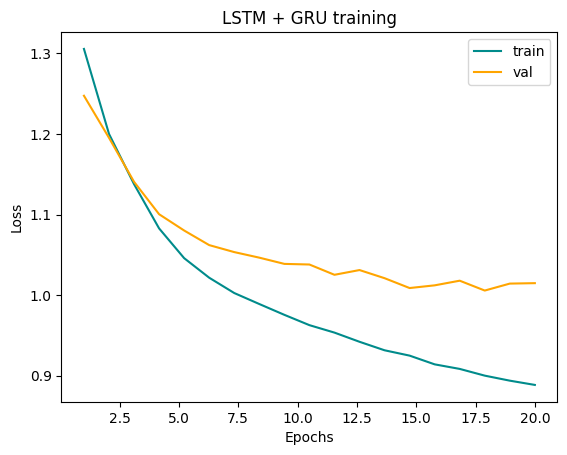

In [41]:
losses = train_VAE(vae,
                   style_classif,
                   adv_style_classif,
                   content_classif,
                   adv_content_classif,
                   train_loader,
                   val_loader,
                   num_epochs = 20,
                   vocab_size= vocab_size,
                   lr = 4e-4)

In [42]:
torch.save(vae.state_dict(), 'lstm_vae_state_dict.pth')
torch.save(style_classif.state_dict(), 'lstm_style_cl_state_dict.pth')

In [ ]:
vae.load_state_dict(torch.load('lstm_vae_state_dict.pth'))
style_classif.load_state_dict(torch.load('lstm_style_cl_state_dict.pth'))

# Ricostruzione

In [43]:
for i ,(data,bow,label) in enumerate(val_loader):
    if i == 0:
        prova = data[0]
        labels = label[0]
        boww = bow[0]

frase = [idx2word[prova[i].item()] for i in range(prova.shape[0])]

prova = prova.view(1,prova.shape[0])

with torch.no_grad():
    reconstructed_sequence, style, content, mu_s, logvar_s, mu_c, logvar_c  = vae(prova)
    reconstructed_sequence2 = vae.reconstruction(prova)

#reconstructed_sequence = reconstructed_sequence.squeeze(0)
#indices = torch.argmax(reconstructed_sequence, dim=-1).squeeze(0)
#indices2 = torch.argmax(reconstructed_sequence2, dim=-1).squeeze(0)
indices = torch.multinomial(F.softmax(reconstructed_sequence.squeeze(0),dim=-1), 1)
indices2 = torch.multinomial(F.softmax(reconstructed_sequence2.squeeze(0),dim=-1), 1)

ricostruzione = []
for i in range(prova.shape[1]):
    ricostruzione.append(idx2word[indices[i].item()])

ricostruzione2 = []
for i in range(prova.shape[1]):
    ricostruzione2.append(idx2word[indices2[i].item()])


if torch.argmax(labels).item() == 0.0:
    stile = 'Dante'
else: 
    stile = 'Italiano'

style = style_classif(style)
print(labels)
print('Stile reale: ', stile)
print('Stile predetto: ', torch.argmax(style).item(), style)
print("Input sequence: \n", ' '.join(frase))
print("\nReconstructed sequence: \n", ' '.join(ricostruzione))
print("\nReconstructed sequence 2: \n", ' '.join(ricostruzione2))

tensor([1, 0])
Stile reale:  Dante
Stile predetto:  0 tensor([[9.9996e-01, 4.2985e-05]], grad_fn=<ViewBackward0>)
Input sequence: 
 lo piacere uman che rinovella seguendo il cielo sempre fu durabile opera naturale è ch

Reconstructed sequence: 
 allora duca e che la il lo sole l l sospesi a e dando tirando

Reconstructed sequence 2: 
 elli dì fiata maggior sciolta privo esce l vista d oltra era in altra è


In [76]:
probs = F.softmax(reconstructed_sequence2.squeeze(0),dim=-1)
h = - (probs * torch.log(probs)).sum(dim=-1).mean()
PPL = 2**h.item()
PPL

32.98469852223156

In [44]:
pred0_styles = []
for n in range(len(style0_val)):
    _, style, _, _, _, _, _ = vae(style0_val[n].view(1,style0_val.shape[1]))
    pred_style = torch.argmax(style_classif(style))
    pred0_styles.append(pred_style)

print('Accuracy predicting Dante style: ', (len(pred0_styles)-np.count_nonzero(pred0_styles))/len(pred0_styles))

Accuracy predicting Dante style:  0.9690265486725663


In [45]:
pred1_styles = []
for n in range(len(style1_val)):
    _, style, _, _, _, _, _ = vae(style1_val[n].view(1,style1_val.shape[1]))
    pred_style = torch.argmax(style_classif(style))
    pred1_styles.append(pred_style)

print('Accuracy predicting Italian style: ', np.count_nonzero(pred1_styles)/len(pred1_styles))

Accuracy predicting Italian style:  0.9941002949852508


# Style transfer

In [142]:
style1_data = torch.cat((style1_train, style1_val), dim=0)
style0_data = torch.cat((style0_train, style0_val), dim=0)

In [46]:
with torch.no_grad():
    reconstructed_sequence, style, content, mu_s, logvar_s, mu_c, logvar_c  = vae(style1_val)


style1 = style.mean(dim=1).unsqueeze(1)

In [47]:
with torch.no_grad():
    reconstructed_sequence, style, content, mu_s, logvar_s, mu_c, logvar_c  = vae(style0_val)


style0 = style.mean(dim=1).unsqueeze(1)

In [238]:
frase = 'nel mezzo del cammin di nostra vita mi ritrovai per una selva oscura'
frase = frase.split()
frase = [word2idx[word] for word in frase]

In [81]:
frase = torch.LongTensor(frase)
with torch.no_grad():
    reconstructed_sequence, style, content, mu_s, logvar_s, mu_c, logvar_c  = vae(frase.unsqueeze(0))
    reconstructed_sequence2 = vae.reconstruction(frase.unsqueeze(0))

#reconstructed_sequence = reconstructed_sequence.squeeze(0)
#indices = torch.argmax(reconstructed_sequence, dim=-1).squeeze(0)
#indices2 = torch.argmax(reconstructed_sequence2, dim=-1).squeeze(0)
indices = torch.multinomial(F.softmax(reconstructed_sequence.squeeze(0),dim=-1), 1)
indices2 = torch.multinomial(F.softmax(reconstructed_sequence2.squeeze(0),dim=-1), 1)

ricostruzione = []
for i in range(frase.shape[0]):
    ricostruzione.append(idx2word[indices[i].item()])

ricostruzione2 = []
for i in range(frase.shape[0]):
    ricostruzione2.append(idx2word[indices2[i].item()])

print("\nReconstructed sequence: \n", ' '.join(ricostruzione))
print("\nReconstructed sequence 2: \n", ' '.join(ricostruzione2))

ValueError: too many dimensions 'str'

In [64]:
n = torch.randint(0,len(style0_val),[1]).item()

with torch.no_grad():    
    transfer_output = vae.style_transfer(style0_val[n].view(1,style0_val.shape[1]), style1)


with torch.no_grad():
    reconstructed, style, content, mu_s, logvar_s, mu_c, logvar_c  = vae(style0_val[n].view(1,style0_val.shape[1]))


#recon_indices = torch.argmax(reconstructed,dim=2).squeeze(0)

#transf_indices = torch.argmax(transfer_output, dim=2).squeeze(0)

transf_indices = torch.multinomial(F.softmax(transfer_output.squeeze(0),dim=-1), 1)
recon_indices = torch.multinomial(F.softmax(reconstructed.squeeze(0),dim=-1), 1)

frase_trasferita = []

for i in range(transfer_output.shape[1]):
    frase_trasferita.append(idx2word[transf_indices[i].item()])

ricostruita = []
for i in range(reconstructed.shape[1]):
    ricostruita.append(idx2word[recon_indices[i].item()])

frase = [idx2word[style0_val[n][i].item()] for i in range(style0_val.shape[1])]


print("From Dante to italian: \n")
print("Input sequence: \n", ' '.join(frase))
print("\nReconstructed sequence: \n", ' '.join(ricostruita))
print("\nTransferred sequence: \n", ' '.join(frase_trasferita))

From Dante to italian: 

Input sequence: 
 cominciò queste parole sante la piaga che maria richiuse e unse quella ch

Reconstructed sequence: 
 chercuti e rote pur sue virtù prove là che lamenti or colei sdegnosa

Transferred sequence: 
 tien così punzelli sue ali lingua queste tante e queste le e fede


In [63]:
transf_indices.shape

torch.Size([13])

In [48]:
tst0_accuracy = []
perplexity01 = []
wo01 = []
for n in range(len(style0_val)):
    with torch.no_grad():    
        transfer_output = vae.TST(style0_val[n].unsqueeze(0), style1)
        #transfer_output = vae.reconstruction(style0_val[n].unsqueeze(0))
        transf_indices = torch.multinomial(F.softmax(transfer_output.squeeze(0),dim=-1), 1)
        #transf_indices = torch.argmax(transfer_output, dim=2)
        transf_indices = transf_indices.permute(1,0)
        pred_style = torch.argmax(CNN_classif(transf_indices), dim=-1)
        tst0_accuracy.append(pred_style.item())

        probs = F.softmax(transfer_output.squeeze(0),dim=-1)
        perplexity = 0
        for i in range(transfer_output.shape[1]):
            perplexity += torch.log(probs[i][transf_indices[0][i]])

        perplexity = torch.exp(- perplexity/sequence_length)
        perplexity01.append(perplexity)
        '''h = - (probs * torch.log(probs)).sum(dim=-1).mean()
        PPL = torch.exp(h)
        perplexity01.append(PPL.item())'''

        x = set(style0_val[n].detach().numpy())
        y = set(transf_indices.flatten().detach().numpy())
        union = x.union(y)
        intersection = x.intersection(y)
        wo01.append(len(list(intersection))/len(list(union)))


accuracy_dan_to_it = np.count_nonzero(tst0_accuracy)/len(tst0_accuracy)
PPL01 = np.mean(perplexity01)
WO01 = np.mean(wo01)
print('STA Dante to Italian: ', accuracy_dan_to_it)
print('Average Perplexity: ', PPL01)
print('Average Word Overlap: ', WO01)

STA Dante to Italian:  0.976401179941003
Average Perplexity:  135.85374
Average Word Overlap:  0.03719054481644426


In [49]:
tst1_accuracy = []
perplexity10 = []
wo10 = []
for n in range(len(style1_val)):
    with torch.no_grad():    
        transfer_output = vae.TST(style1_val[n].unsqueeze(0), style0)
        #transfer_output = vae.reconstruction(style1_val[n].unsqueeze(0))
        transf_indices = torch.multinomial(F.softmax(transfer_output.squeeze(0),dim=-1), 1)
        #transf_indices = torch.argmax(transfer_output, dim=2)
        transf_indices = transf_indices.permute(1,0)
        pred_style = torch.argmax(CNN_classif(transf_indices), dim=-1)
        tst1_accuracy.append(pred_style.item())

        probs = F.softmax(transfer_output.squeeze(0),dim=-1)
        perplexity = 0
        for i in range(transfer_output.shape[1]):
            perplexity += torch.log(probs[i][transf_indices[0][i]])

        perplexity = torch.exp(- perplexity/sequence_length)
        perplexity10.append(perplexity)

        '''h = - (probs * torch.log(probs)).sum(dim=-1).mean()
        PPL = torch.exp(h)
        perplexity10.append(PPL.item())'''

        x = set(style1_val[n].detach().numpy())
        y = set(transf_indices.flatten().detach().numpy())
        union = x.union(y)
        intersection = x.intersection(y)
        wo10.append(len(list(intersection))/len(list(union)))


accuracy_it_to_dan = (len(style1_val)-np.count_nonzero(tst1_accuracy))/len(tst1_accuracy)
PPL10 = np.mean(perplexity10)
WO10 = np.mean(wo10)
print('STA Italian to Dante: ', accuracy_it_to_dan)
print('Average Perplexity: ', PPL10)
print('Average Word Overlap: ', WO10)

STA Italian to Dante:  0.967551622418879
Average Perplexity:  327.7607
Average Word Overlap:  0.02355720394653362


In [50]:
print('Overall STA: ', (accuracy_dan_to_it + accuracy_it_to_dan)/2)
print('Overall Perplexity: ', (PPL01 + PPL10)/2)
print('Overall Word Overlap: ', (WO01 + WO10)/2)

Overall STA:  0.971976401179941
Overall Perplexity:  231.80722045898438
Overall Word Overlap:  0.03037387438148894


In [179]:
(np.count_nonzero(tst0_accuracy)+len(style1_val)-np.count_nonzero(tst1_accuracy))/(len(tst0_accuracy)+len(tst1_accuracy))

0.8326771653543307

In [97]:
n = torch.randint(0,len(style1_val),[1]).item()

with torch.no_grad():    
    transfer_output = vae.style_transfer(style1_val[n].view(1,style1_val.shape[1]), style0)


with torch.no_grad():
    reconstructed, style, content, mu_s, logvar_s, mu_c, logvar_c  = vae(style1_val[n].view(1,style1_val.shape[1]))


#index = torch.argmax(reconstructed,dim=2)

#indices = torch.argmax(transfer_output, dim=2)

transf_indices = torch.multinomial(F.softmax(transfer_output.squeeze(0),dim=-1), 1)
recon_indices = torch.multinomial(F.softmax(reconstructed.squeeze(0),dim=-1), 1)

frase_trasferita = []

for i in range(transfer_output.shape[1]):
    frase_trasferita.append(idx2word[transf_indices[i].item()])

ricostruita = []
for i in range(transfer_output.shape[1]):
    ricostruita.append(idx2word[recon_indices[i].item()])

frase = [idx2word[style1_val[n][i].item()] for i in range(style1_val.shape[1])]


print("From italin to Dante: \n")
print("Input sequence: \n", ' '.join(frase))
print("\nReconstructed sequence: \n", ' '.join(ricostruita))
print("\nTransferred sequence: \n", ' '.join(frase_trasferita))

From italin to Dante: 

Input sequence: 
 che andava e veniva per niente e faceva il viaggio del sale e

Reconstructed sequence: 
 non voleva ad tutta alla tutti cinghialenta maritati lì dannosa colla mondo nostri

Transferred sequence: 
 sempre ci borbottando frigido le la altrimenti perchè da corsa avvertirvi lavorato dal


In [31]:
class CNNClassifier(nn.Module):
    def __init__(self, embedding_matrix, num_classes, sequence_length, num_filters, kernel_sizes):
        super(CNNClassifier, self).__init__()
        self.embedding_dim = embedding_matrix.shape[1]

        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze = True)
        self.conv_layers = nn.ModuleList([nn.Conv2d(1, num_filters, (k, self.embedding_dim)) for k in kernel_sizes])
        self.fc = nn.Linear(num_filters * len(kernel_sizes), num_classes)
        
    def forward(self,x):
        x = self.embedding(x)
        x = x.unsqueeze(1)
        conv_results = [F.relu(conv(x)).squeeze(3) for conv in self.conv_layers]
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conv_results]
        cat = torch.cat(pooled, dim = 1)
        out = self.fc(cat)
        return F.softmax(out, dim=-1)

In [32]:
def CNN_loss(y_s, labels, loss_fn=nn.BCELoss()):
    L_mul_s = loss_fn(y_s, labels)

    return L_mul_s

In [33]:
def train_CNN(style_classif, train_loader, val_loader, num_epochs, lr = 4e-4):
    params = list(style_classif.parameters())

    optimizer = torch.optim.Adam(params, lr = lr)

    average_losses = []
    val_losses = []
    
    for epoch in tqdm(range(num_epochs)):
        train_loss = 0.0
        average_loss = 0.0
        val_loss = 0.0
        average_val_loss = 0.0
        
        #model.train()
        for  i, (data, bow, labels) in enumerate(train_loader):
            data = data.to(device)
            labels = labels.type(torch.FloatTensor)

            optimizer.zero_grad()


            pred_style = style_classif(data)
            
            #data = data.type(torch.FloatTensor)
            loss_tot = CNN_loss(pred_style, labels)
            loss_tot.backward()
            train_loss += loss_tot.item()


            optimizer.step()
            
            if (i + 1) % 5000 == 0:
                print(f'Train Epoch: {epoch+1} [{i * len(data)}/{len(train_loader.dataset)} ({100. * i / len(train_loader):.0f}%)]\tLoss: {loss_tot.item() / len(data):.6f}')
        
        
        average_loss = train_loss / len(train_loader.dataset)
        #plt.plot(epoch+1,average_loss)
        print(f'====> Epoch: {epoch+1} Average loss: {average_loss:.4f}')
        average_losses.append(average_loss)

        with torch.no_grad():
            for i, (data, bow, labels) in enumerate(val_loader):
                data = data.to(device)
                labels = labels.type(torch.FloatTensor)
                

                pred_style = style_classif(data)

                
                #data = data.type(torch.FloatTensor)
                val_loss_tot = CNN_loss(pred_style, labels)
                val_loss += val_loss_tot.item()


                
                if (i + 1) % 5000 == 0:
                    print(f'Train Epoch: {epoch+1} [{i * len(data)}/{len(val_loader.dataset)} ({100. * i / len(val_loader):.0f}%)]\tLoss: {val_loss_tot.item() / len(data):.6f}')
            
            
        average_val_loss = val_loss / len(val_loader.dataset)
        #print(f'====> Epoch: {epoch+1} Average loss: {average_val_loss:.4f}')
        val_losses.append(average_val_loss)

    
    plt.plot(np.linspace(1,num_epochs,len(average_losses)), average_losses, c = 'darkcyan',label = 'train')
    plt.plot(np.linspace(1,num_epochs,len(val_losses)), val_losses, c = 'orange',label = 'val')
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()
    return average_losses

In [34]:
CNN_classif = CNNClassifier(embedding_matrix, 2, sequence_length, 3, [3,3,3])

In [35]:
style_params = sum(p.numel() for p in CNN_classif.parameters() if p.requires_grad)
print('Total parameters: ', style_params)

Total parameters:  8129


 25%|██▌       | 1/4 [00:02<00:06,  2.22s/it]

====> Epoch: 1 Average loss: 0.0041


 50%|█████     | 2/4 [00:03<00:03,  1.93s/it]

====> Epoch: 2 Average loss: 0.0020


 75%|███████▌  | 3/4 [00:05<00:01,  1.86s/it]

====> Epoch: 3 Average loss: 0.0014


100%|██████████| 4/4 [00:07<00:00,  1.87s/it]

====> Epoch: 4 Average loss: 0.0009


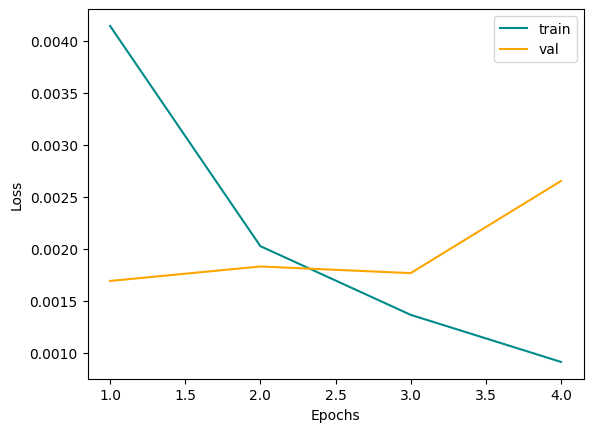

In [36]:
CNN_losses = train_CNN(CNN_classif,
                   train_loader,
                   val_loader,
                   num_epochs = 4,
                   lr = 1e-3)

In [37]:
wrong = 0.0
wrongy = []
with torch.no_grad():
    for i, (data, _, labels) in enumerate(val_loader):
        pred_style = torch.argmax(CNN_classif(data), dim=-1)
        label = torch.argmax(labels,dim=-1)
        wrong += torch.count_nonzero(label - pred_style)
        
print('Accuracy :', 1 - (wrong/(len(val_loader)*batch_size)).item(), '%')

Accuracy : 0.9709302317351103 %


In [100]:
transf_indices = transf_indices.permute(1,0)

In [101]:
with torch.no_grad():
    pred_style = torch.argmax(CNN_classif(transf_indices), dim=-1)

In [102]:
pred_style

tensor([0])